In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

## Fitting Models

In [2]:
# constants
FILE_PATH = "cars.csv"
WITH_FEATURES_PATH = "cars-with-features.csv"
SEED = 42

### Dataset Preparation

In [3]:
# load in the data frame
df_with_features = pd.read_csv(WITH_FEATURES_PATH)

In [4]:
# One-hot encode certain columns
df_linreg = df_with_features.copy()
columns_to_encode = ['Brand', 'Model', 'Status']

encoder = OneHotEncoder()
onehot_encoded = encoder.fit_transform(df_with_features[columns_to_encode])
onehot_encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))

df_linreg = pd.concat([df_linreg, onehot_encoded_df], axis=1)

In [5]:
# Normalize columns to be between 1 and 0
df_linreg['Age'] = (df_linreg['Age'] - df_linreg['Age'].min()) / (df_linreg['Age'].max() - df_linreg['Age'].min())
df_linreg['Mileage'] = (df_linreg['Mileage'] - df_linreg['Mileage'].min()) / (df_linreg['Mileage'].max() - df_linreg['Mileage'].min())
df_linreg['Yearly_Miles'] = (df_linreg['Yearly_Miles'] - df_linreg['Yearly_Miles'].min()) / (df_linreg['Yearly_Miles'].max() - df_linreg['Yearly_Miles'].min())

In [6]:
# Filter Outliers
df_linreg = df_linreg[df_linreg['Price'] <= 175000]
df_linreg = df_linreg[df_linreg['Age'] <= 15]
df_linreg = df_linreg[df_linreg['Mileage'] <= 200000]

In [7]:
# Final Data cleaning
df_linreg = df_linreg.drop(columns=['Brand', 'Model', 'Status', 'PriceRange', 'Dealer', 'Year'])

df_linreg.replace([np.inf, -np.inf], np.nan, inplace=True)
df_linreg = df_linreg.dropna()

In [8]:
df_linreg

,Mileage,Price,Age,Yearly_Miles,Brand_audi,Brand_bmw,Brand_cadillac,Brand_chevrolet,Brand_dodge,Brand_ford,...,Model_xterra,Model_xts,Model_yaris,Model_yukon,Model_z,Model_z sport,Model_z4,Status_certified,Status_new,Status_used
0,0.000000,28990.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.003874,58900.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.034703,34000.0,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.171096,56954.0,0.046154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.000000,61715.0,0.015385,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41369,0.000000,50635.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41370,0.000000,122455.0,0.015385,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41371,0.000000,125930.0,0.015385,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41372,0.000000,53715.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
X = df_linreg.drop('Price', axis=1)
y = df_linreg['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Logistic Regression

In [10]:
model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [11]:
# Visualize differnece between truth and predictions
predictions_df = pd.DataFrame({'Actual_Labels': y_test, 'Predictions': y_pred}, index=X_test.index)
predictions_df['Difference'] = predictions_df['Actual_Labels'] - predictions_df['Predictions']
predictions_df['Hits'] = np.where(np.abs(predictions_df['Difference']) <= 5000, 1, 0)

print(round(predictions_df['Hits'].sum()/5742, 2))

0.53


In [12]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pcc, _ = pearsonr(y_true, y_pred)
    return mse, r2, pcc

print("Logistic Regression\tMSE\tR^2\tPCC")
print(" Test set: \t\t{:.3f} \t{:.3f} \t{:.3f}".format(*evaluate(y_test, y_pred)))

Logistic Regression	MSE	R^2	PCC
 Test set: 		154717161.445 	0.761 	0.873


### XGBoost Decision Tree

In [13]:
df_xgb = df_with_features.copy()

# Filter Outliers
df_xgb = df_xgb[df_xgb['Price'] <= 175000]
df_xgb = df_xgb[df_xgb['Age'] <= 15]
df_xgb = df_xgb[df_xgb['Age'] <= 200000]

df_xgb.replace([np.inf, -np.inf], np.nan, inplace=True)
df_xgb = df_xgb.dropna()

In [14]:
label_encoder = LabelEncoder()

# save og categorical variables 
X_Brand = df_xgb['Brand']
X_Model = df_xgb['Model']
X_Status = df_xgb['Status']
Y_PriceRange = df_xgb['PriceRange']

# label encode the categorical variables
df_xgb["Brand"] = label_encoder.fit_transform(df_xgb["Brand"])
df_xgb["Model"] = label_encoder.fit_transform(df_xgb["Model"])
df_xgb["Status"] = label_encoder.fit_transform(df_xgb["Status"])
y = label_encoder.fit_transform(Y_PriceRange)

X = df_xgb.drop(columns=['PriceRange','Dealer', 'Price', 'Year'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train

,Brand,Model,Status,Mileage,Age,Yearly_Miles
26421,9,152,1,0.0,1,0.00
11775,5,200,1,0.0,1,0.00
16559,6,262,1,0.0,1,0.00
18091,3,263,2,60326.0,11,5484.18
5202,10,258,0,29704.0,2,14852.00
...,...,...,...,...,...,...
20458,3,80,2,69672.0,7,9953.14
7409,4,74,1,0.0,1,0.00
13501,0,242,1,0.0,1,0.00
998,5,60,1,0.0,1,0.00


In [15]:
'''TAKES 10 MINUETS TO RUN'''

# param_grid = {
#     'n_estimators': [175, 225, 150],
#     'max_depth': [11, 13, 15],
#     'learning_rate': [0.15, 0.1, 0.8]
# }

# xgb_model = xgb.XGBClassifier(random_state=SEED)
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)

# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

'TAKES 10 MINUETS TO RUN'

In [16]:
xgb_model = xgb.XGBClassifier(
    n_estimators=150,  
    max_depth=9,  
    learning_rate=0.1, 
    random_state=SEED
)

xgb_fitted = xgb_model.fit(X_train, y_train)
y_pred = xgb_fitted.predict(X_test)
y_pred_proba = xgb_fitted.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Pred_proba:", accuracy)

Accuracy: 0.51253895236682
Pred_proba: 0.51253895236682


              precision    recall  f1-score   support

           0       0.72      0.65      0.68       141
           1       0.74      0.74      0.74       582
           2       0.30      0.43      0.36        75
           3       0.55      0.34      0.42        65
           4       0.28      0.19      0.23        26
           5       0.36      0.19      0.24        27
           6       0.25      0.14      0.18        14
           7       0.25      0.25      0.25        16
           8       0.58      0.35      0.44        20
           9       0.00      0.00      0.00         5
          10       0.63      0.68      0.65       972
          11       0.58      0.58      0.58      1163
          12       0.52      0.56      0.54      1240
          13       0.39      0.39      0.39       907
          14       0.36      0.37      0.36       628
          15       0.34      0.43      0.38       410
          16       0.34      0.16      0.22       291
          17       0.27    

G:\My Drive\School\4-Senior-Fall\CS-584 Machine Learning\assignments\ML-584-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\My Drive\School\4-Senior-Fall\CS-584 Machine Learning\assignments\ML-584-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
G:\My Drive\School\4-Senior-Fall\CS-584 Machine Learning\assignments\ML-584-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

<Figure size 3000x2400 with 0 Axes>

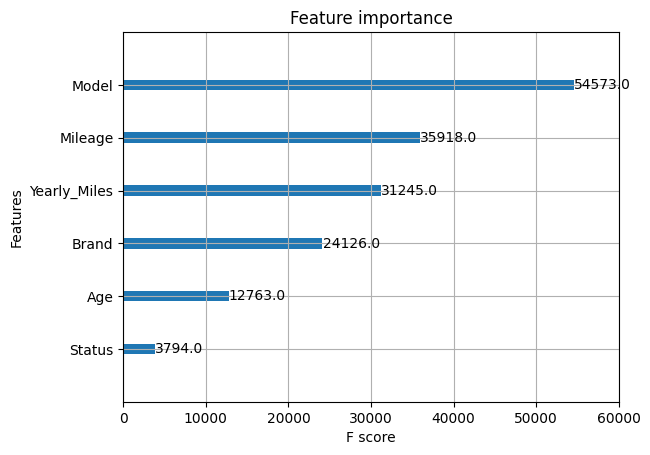

In [17]:
from xgboost import plot_importance

f = plt.figure(figsize=[30,24])
matplotlib.rcParams.update({'font.size': 10})
plot_importance(xgb_fitted, max_num_features=20)
print(classification_report(y_test,y_pred))

y_pred_proba = xgb_fitted.predict_proba(X_test)[:, 1]

## Multi-layer Perceptron regressor

In [18]:
from sklearn.neural_network import MLPRegressor

# Network has 3 hidden layers with 50, 5, and 2 neurons
regr_model = MLPRegressor(random_state=SEED, max_iter=1000, early_stopping=True, hidden_layer_sizes=(50,5,2))
regr_fitted = regr_model.fit(X_train, y_train)

In [19]:
y_pred = regr_fitted.predict(X_test)
evaluate(y_test, y_pred)
print("Multi-layer Perceptron regressor\tMSE\tR^2\tPCC")
print(" Test set: \t\t\t\t{:.3f} \t{:.3f} \t{:.3f}".format(*evaluate(y_test, y_pred)))

Multi-layer Perceptron regressor	MSE	R^2	PCC
 Test set: 				9.931 	0.439 	0.665
